In [1]:
import os
os.chdir('/Users/rv/Projects/7CS074') # Change to the project root directory

import pandas as pd

import global_vars 

from sklearn.model_selection import train_test_split

from evaluation import select_best_model_cv
from features import engineer_features
from models import get_type_models

In [2]:
# First we will check and run the preprocessing script
# In case this is already done, this will not overwrite existing files
from preprocessing import process_raw_multiple_data_files

process_raw_multiple_data_files()

In [3]:
if not os.path.exists(global_vars.DATASET_CLEAN_FILE_PATH):
    raise FileNotFoundError(f"Dataset not found at {global_vars.DATASET_CLEAN_FILE_PATH}. Please ensure the dataset is placed correctly.")

df = pd.read_csv(global_vars.DATASET_CLEAN_FILE_PATH, sep=',', engine='python') # read with proper delimiter handling, and with python engine always
if df.empty:
    raise ValueError("Loaded dataset is empty. Please check the dataset file.")

print(f"Data loaded successfully from {global_vars.DATASET_CLEAN_FILE_PATH}.")

target_col = 'price'

min_samples_per_make=300
cv_splits=5

trained_models_per_make = {}

Data loaded successfully from /Users/rv/Projects/7CS074/data/clean/cleaned_dataset.csv.


In [4]:
candidate_models = get_type_models('regression')

X_global, global_encoder = engineer_features(
    df,
    global_vars.CATEGORICAL_FEATURES_GLOBAL
)
Y_global = df[target_col]

global_X_train, global_X_test, global_y_train, global_y_test = train_test_split(
    X_global, Y_global, test_size=0.2, random_state=42
)

global_best_name, global_best_model, global_cv_scores = select_best_model_cv(
    global_X_train, global_y_train, candidate_models, cv_splits
)

global_predictions = global_best_model.predict(global_X_test)
global_feature_names = global_X_train.columns

current_year 2026


In [5]:
# Per-make models
# If the length of each dataframe of group is lower than the minimum sample variable, we shall pass and not create a 'per-make' model
# This is to make sure that algorithms like 'Random Forrest' gets trained on larger sets of data, as indented, if the condition is true, the make would fallback into the global model above.
for make, group_df in df.groupby("make"):
    if len(group_df) < min_samples_per_make:
        continue
    
    X, encoder = engineer_features(
        group_df, 
        global_vars.CATEGORICAL_FEATURES_PER_MAKE
    )
    Y = group_df[target_col]

    X_train, X_test, y_train, y_test = train_test_split(
        X, Y, test_size=0.2, random_state=42
    )

    best_name, best_model, cv_scores = select_best_model_cv(
        X_train, y_train, candidate_models, cv_splits
    )

    predictions = best_model.predict(X_test)
    trained_models_per_make[make] = {
        "model": best_model,
        "encoder": encoder,
        "feature_names": X_train.columns,
        "X_test": X_test,
        "y_test": y_test,
        "predictions": predictions,
    }

current_year 2026
current_year 2026
current_year 2026
current_year 2026
current_year 2026
current_year 2026
current_year 2026
current_year 2026
current_year 2026


In [6]:
from evaluation import regression_metrics

global_metrics = regression_metrics(y_test, predictions)

In [7]:
print(f"\n Overall Dataset:")
print(f"  Best Model: {global_best_name}")
print(f"  MAE: £{global_metrics['MAE']:.2f}")
print(f"  RMSE: £{global_metrics['RMSE']:.2f}")
print(f"  R²: {global_metrics['R2']:.3f}")
print(f"  MAPE: {global_metrics['MAPE']:.2f}%")

for make_vehicle, data in trained_models_per_make.items():
	y_test = data['y_test']
	predictions = data['predictions']
	metrics = regression_metrics(y_test, predictions)

	print(f"\n{make_vehicle}:")
	print(f"  Best Model: {data['model']}")
	print(f"  MAE: £{metrics['MAE']:.2f}")
	print(f"  RMSE: £{metrics['RMSE']:.2f}")
	print(f"  R²: {metrics['R2']:.3f}")
	print(f"  MAPE: {metrics['MAPE']:.2f}%")


 Overall Dataset:
  Best Model: random_forest
  MAE: £1260.61
  RMSE: £1741.43
  R²: 0.913
  MAPE: 6.09%

audi:
  Best Model: RandomForestRegressor(min_samples_leaf=5, n_estimators=300, n_jobs=5,
                      random_state=42)
  MAE: £1647.75
  RMSE: £2304.68
  R²: 0.878
  MAPE: 6.46%

bmw:
  Best Model: RandomForestRegressor(min_samples_leaf=5, n_estimators=300, n_jobs=5,
                      random_state=42)
  MAE: £1806.76
  RMSE: £2599.17
  R²: 0.909
  MAPE: 6.90%

ford:
  Best Model: RandomForestRegressor(min_samples_leaf=5, n_estimators=300, n_jobs=5,
                      random_state=42)
  MAE: £971.06
  RMSE: £1312.87
  R²: 0.902
  MAPE: 6.76%

hyundi:
  Best Model: RandomForestRegressor(min_samples_leaf=5, n_estimators=300, n_jobs=5,
                      random_state=42)
  MAE: £863.85
  RMSE: £1236.95
  R²: 0.940
  MAPE: 6.77%

mercedes:
  Best Model: RandomForestRegressor(min_samples_leaf=5, n_estimators=300, n_jobs=5,
                      random_state=42)
  MAE

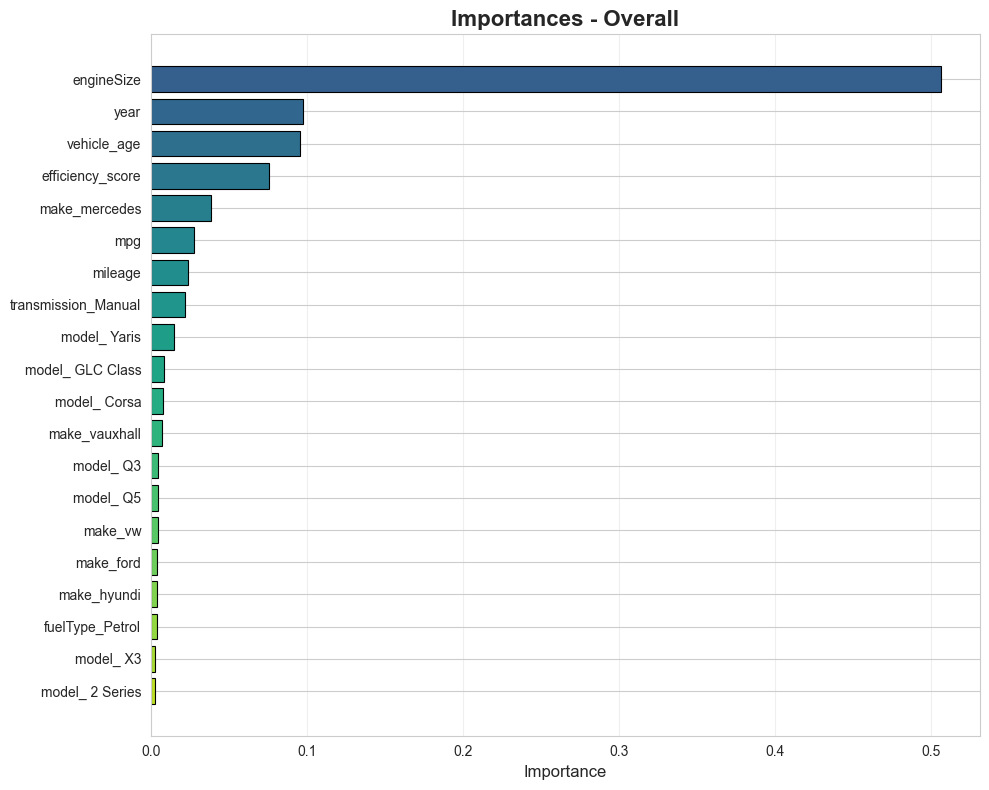

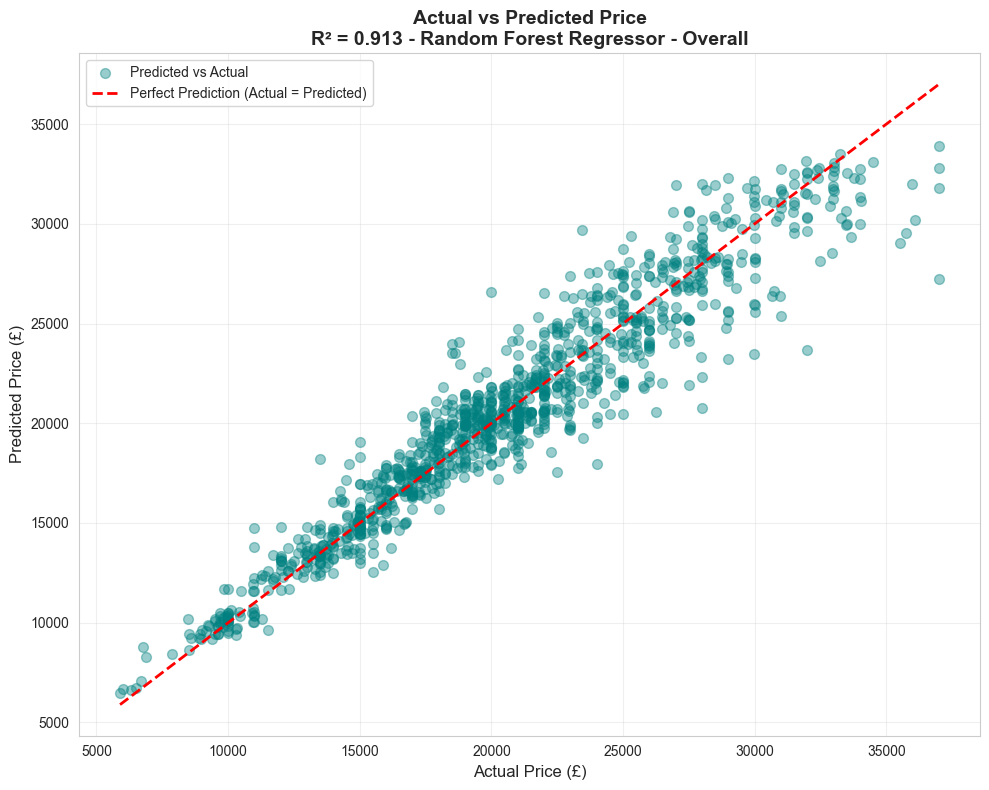

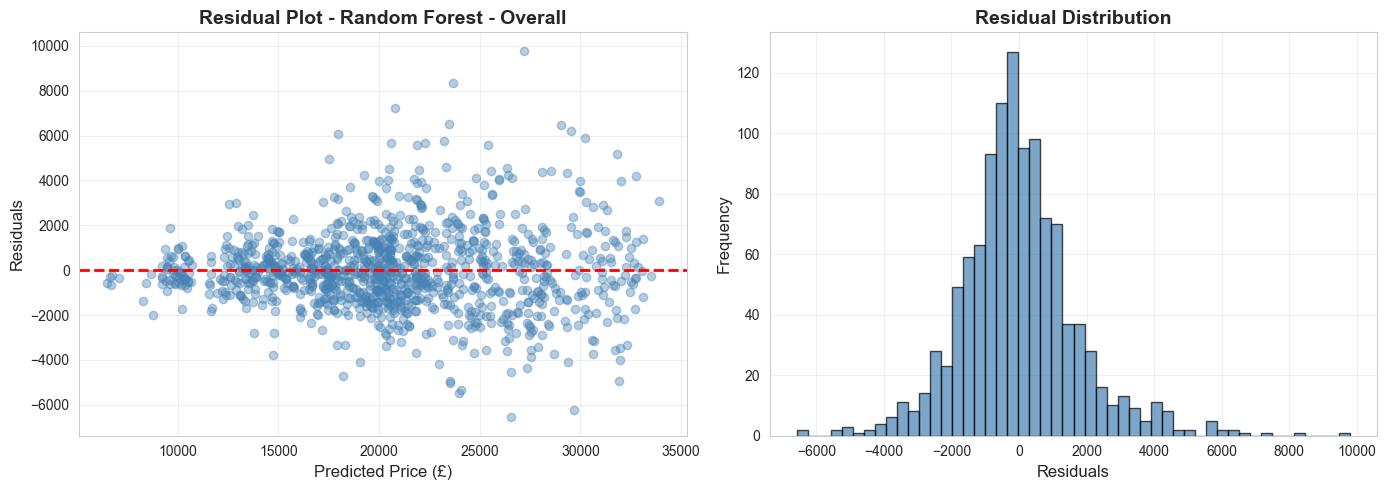

In [8]:
from features import get_feature_effects
from visualisation import plot_actual_vs_predicted, plot_feature_importances, plot_residuals

values, kind = get_feature_effects(global_best_model)

plot_feature_importances(
	values,
	global_feature_names,
	f"{kind.title()}s - Overall"
)

# Actual vs Predicted
plot_actual_vs_predicted(
	y_test, 
	predictions, 
	f'Random Forest Regressor - Overall', 
	metrics['R2']
)

# Residuals plot
plot_residuals(
	y_test, 
	predictions, 
	f'Random Forest - Overall'
)

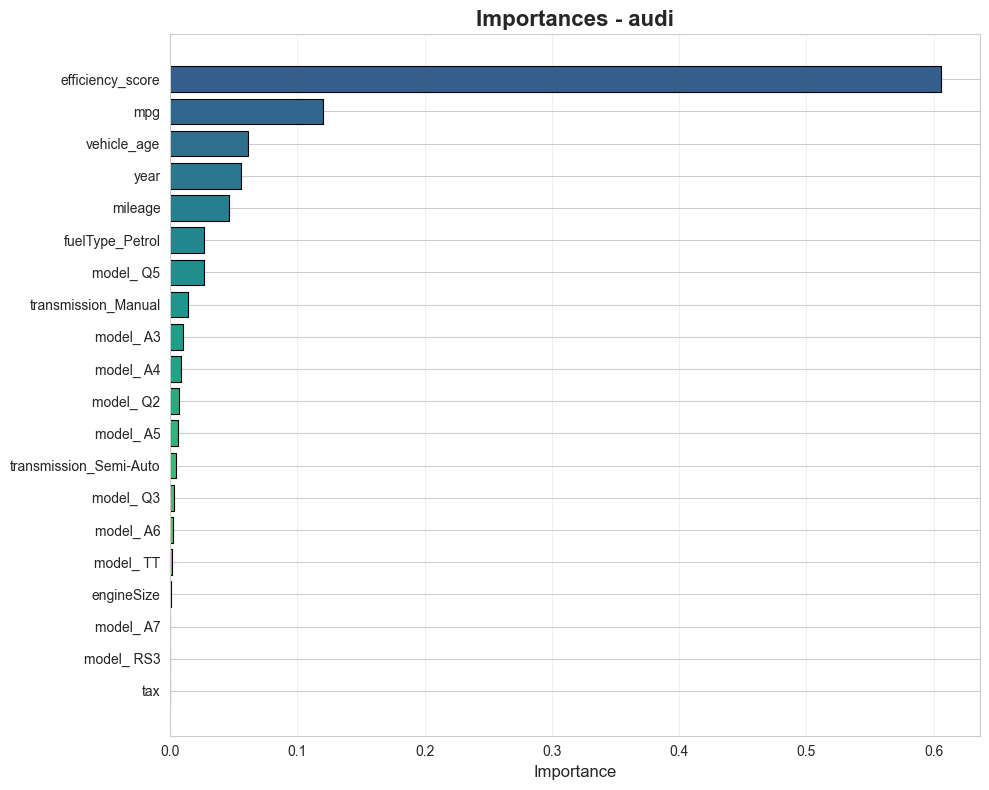

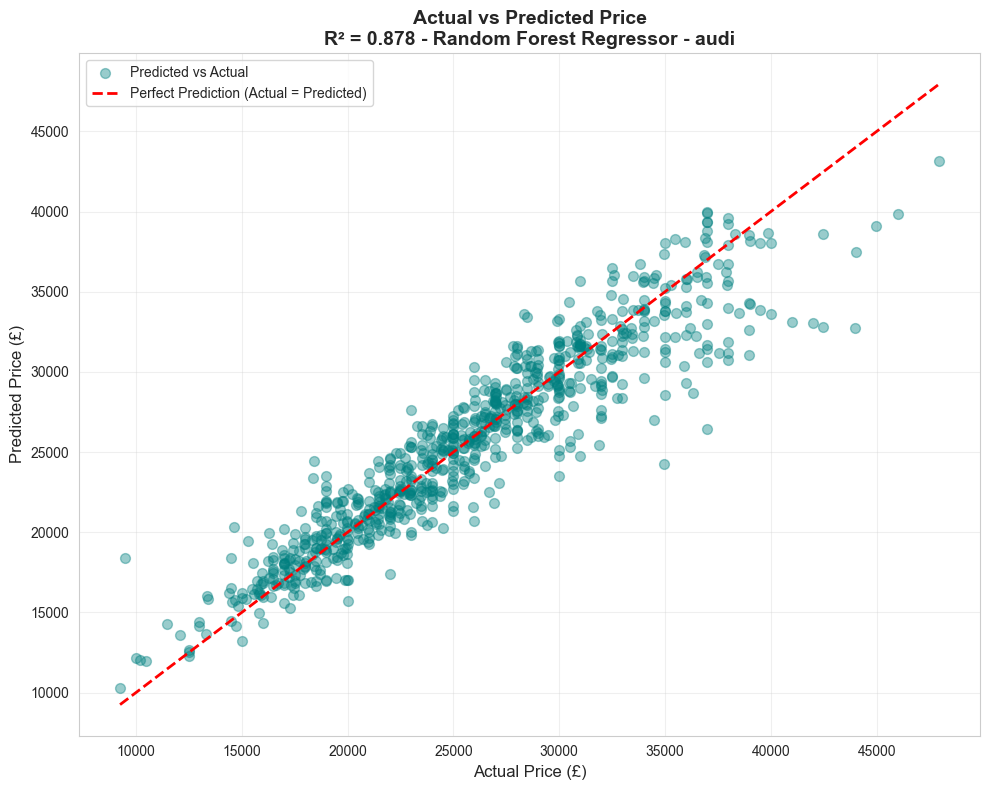

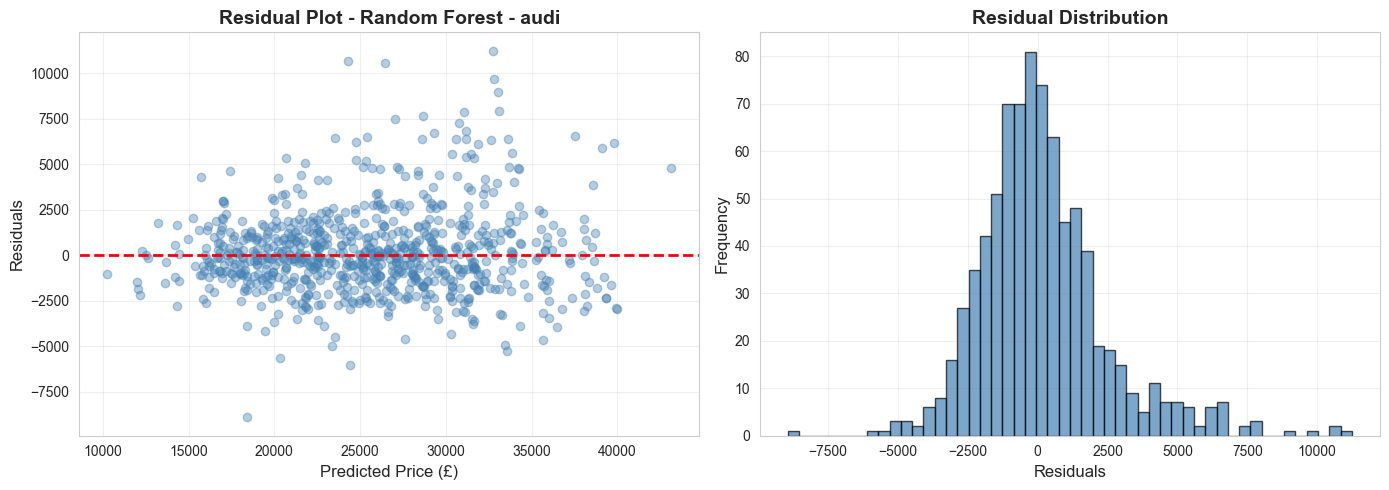

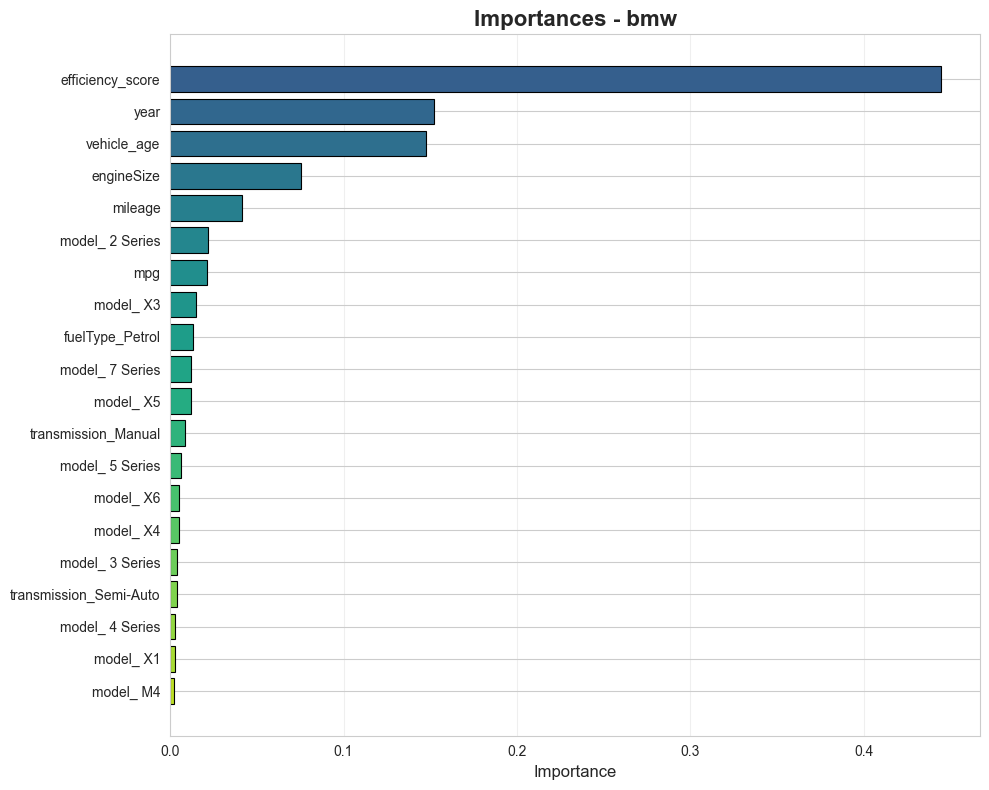

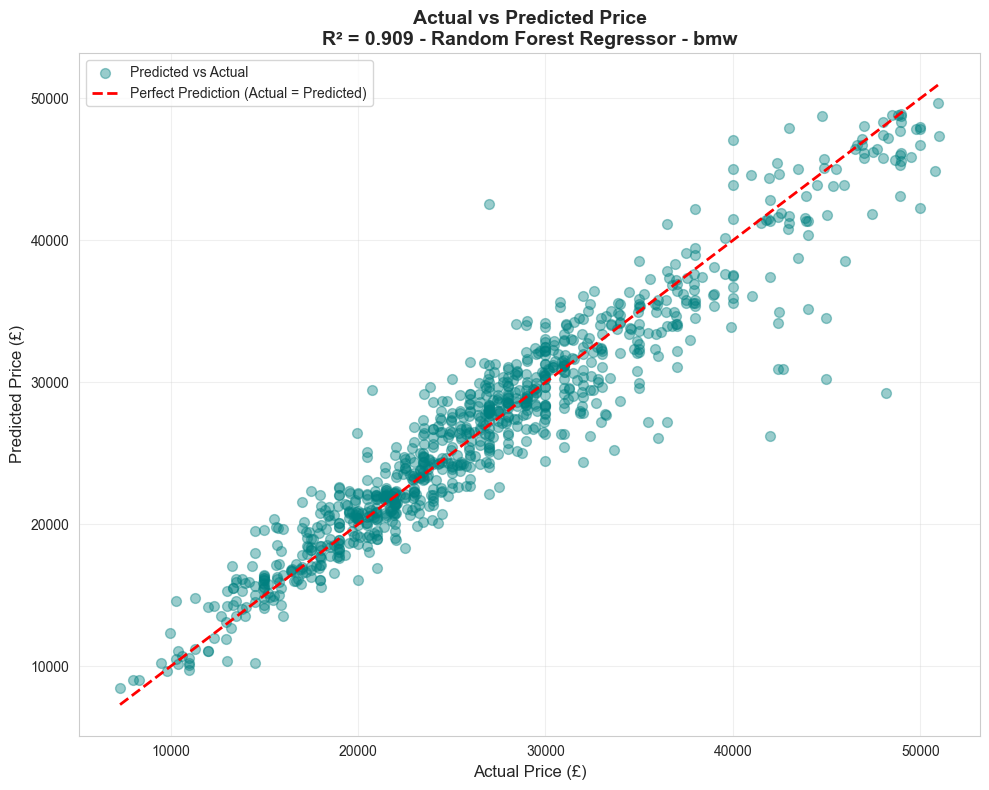

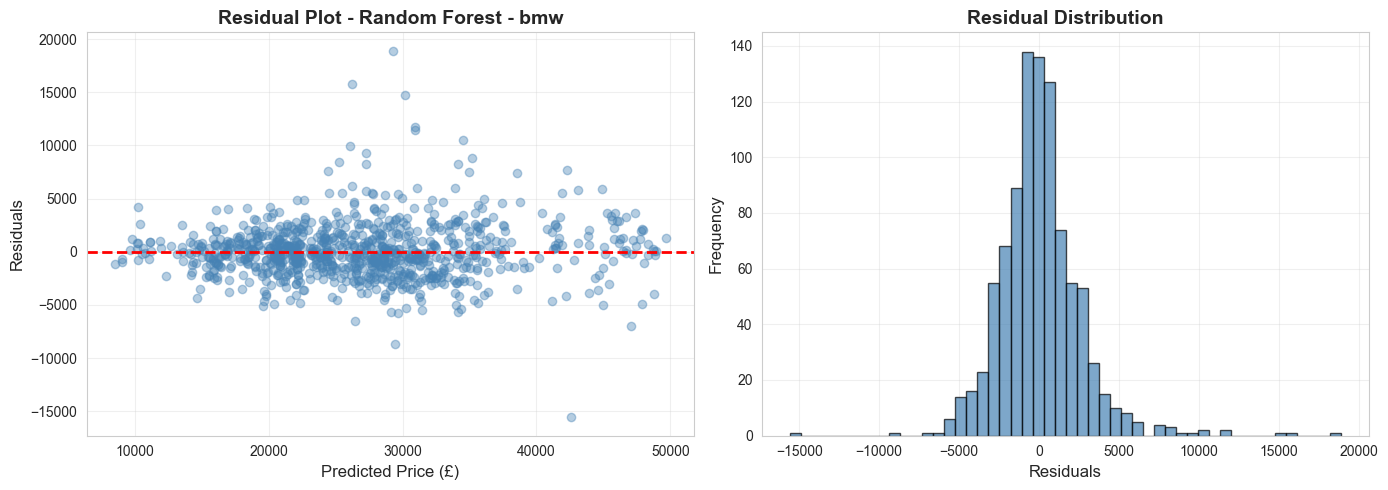

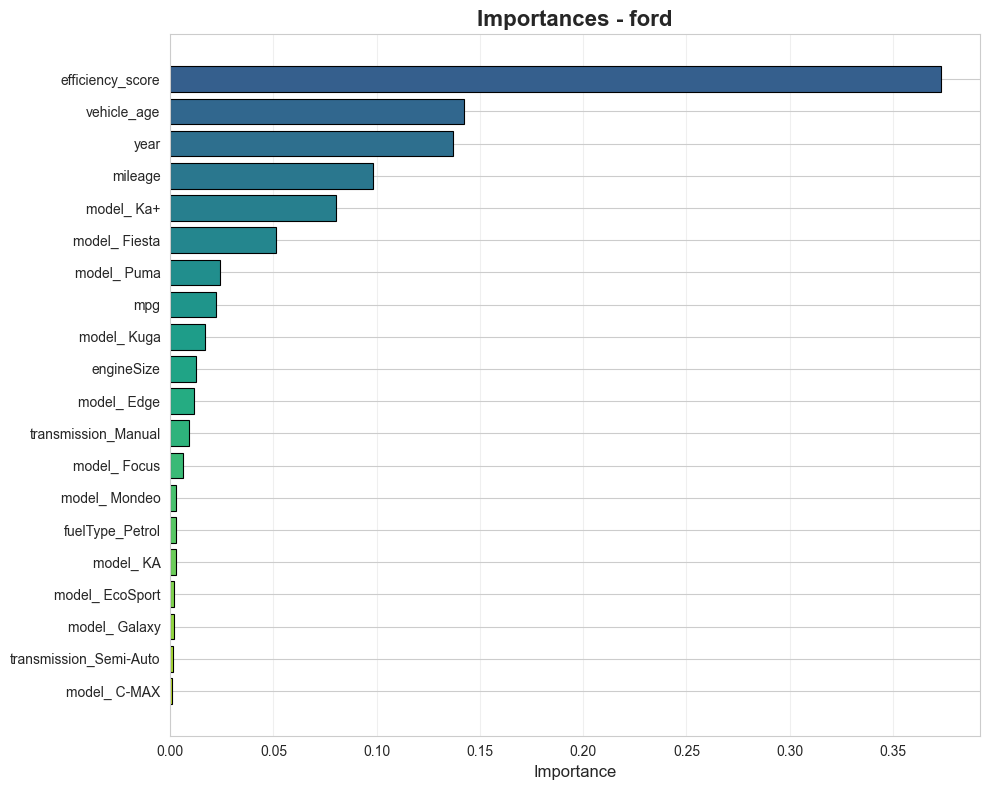

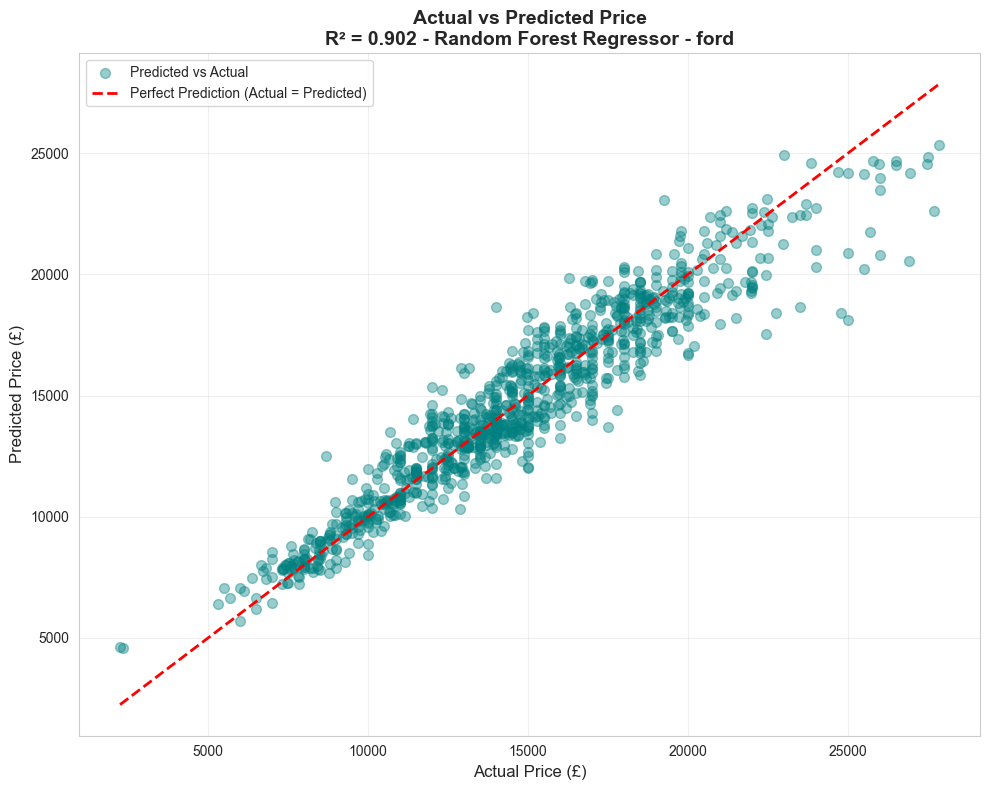

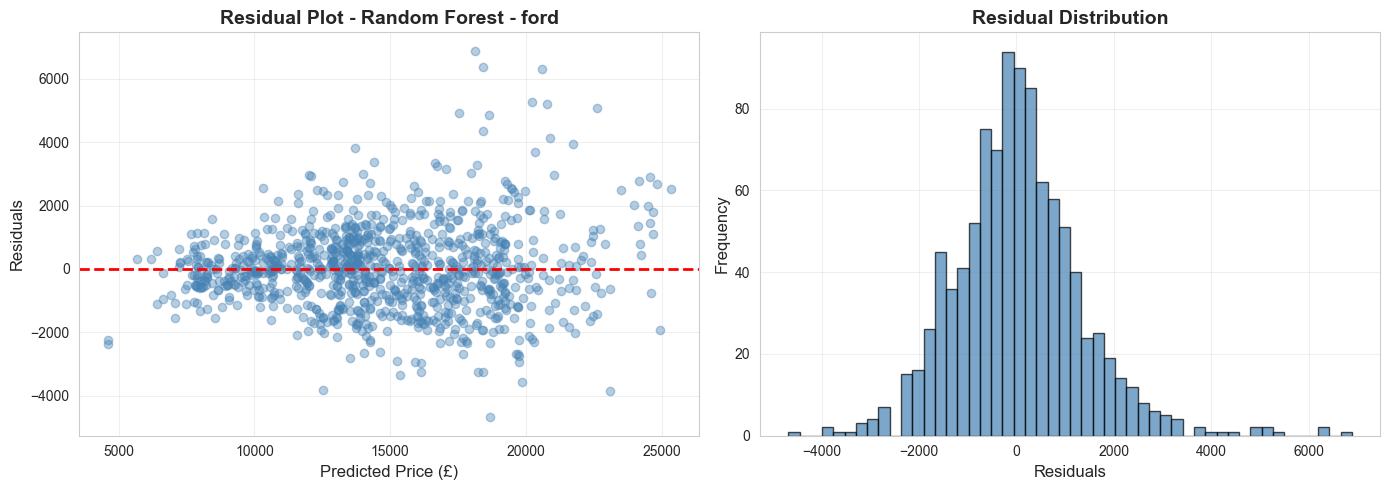

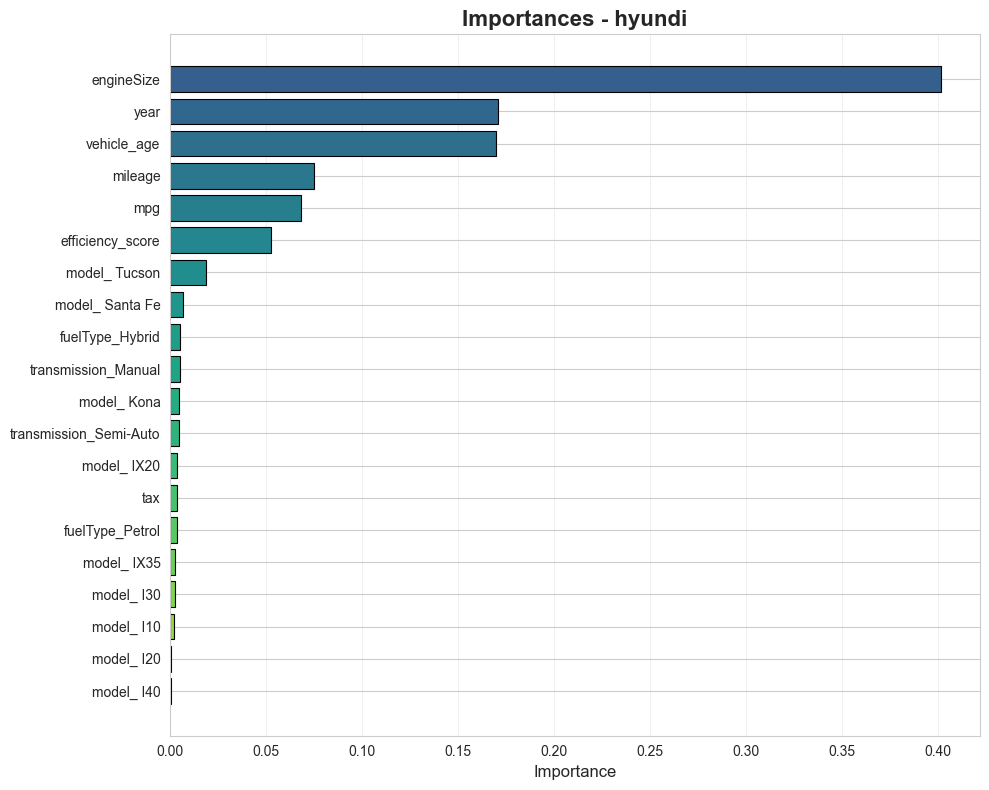

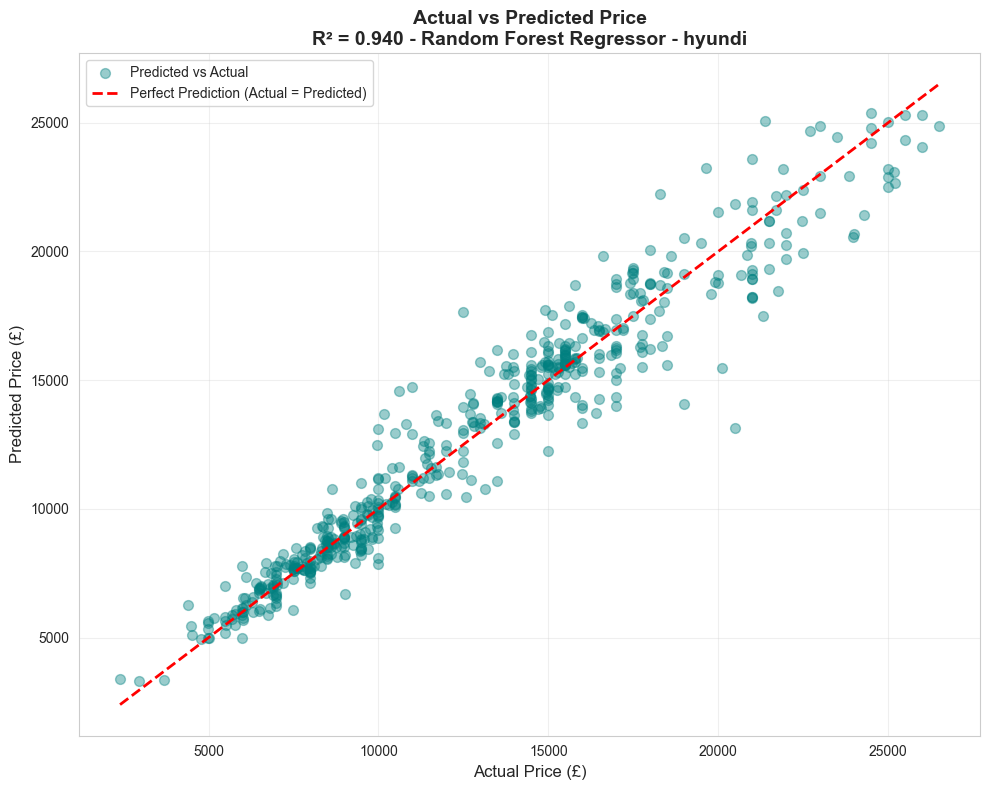

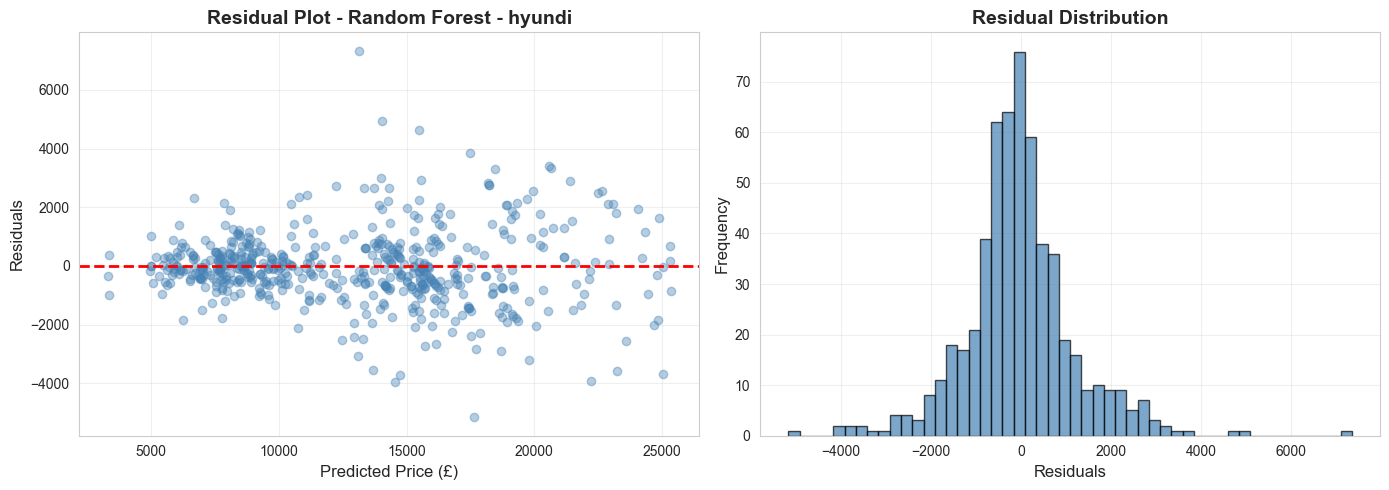

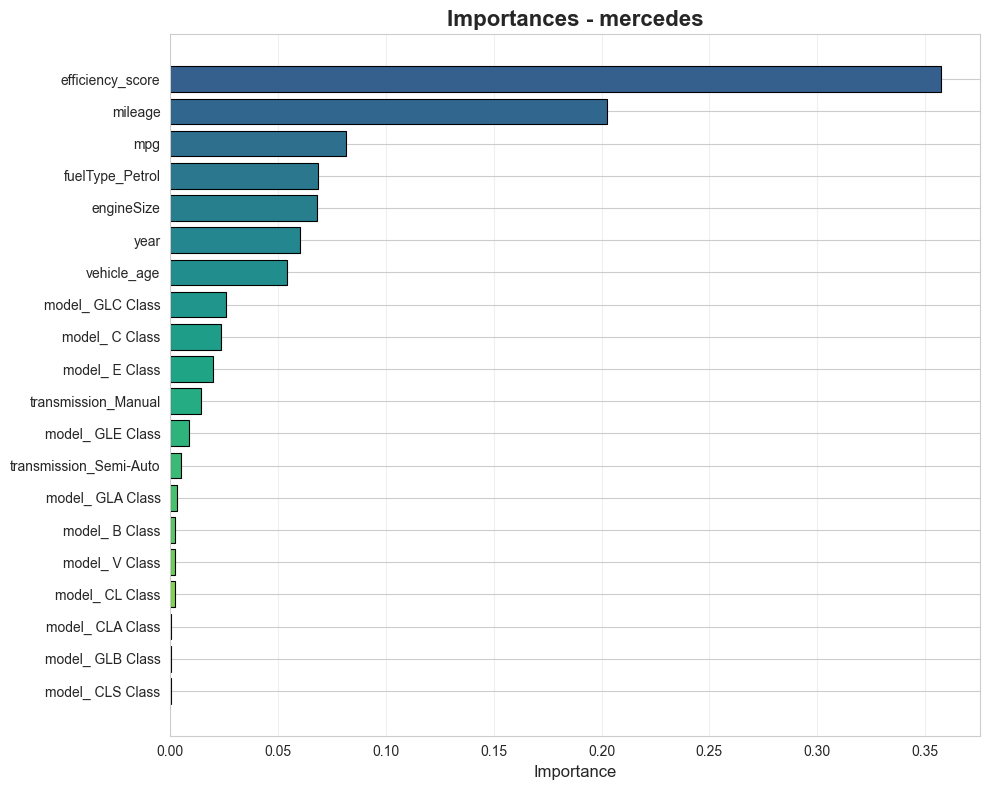

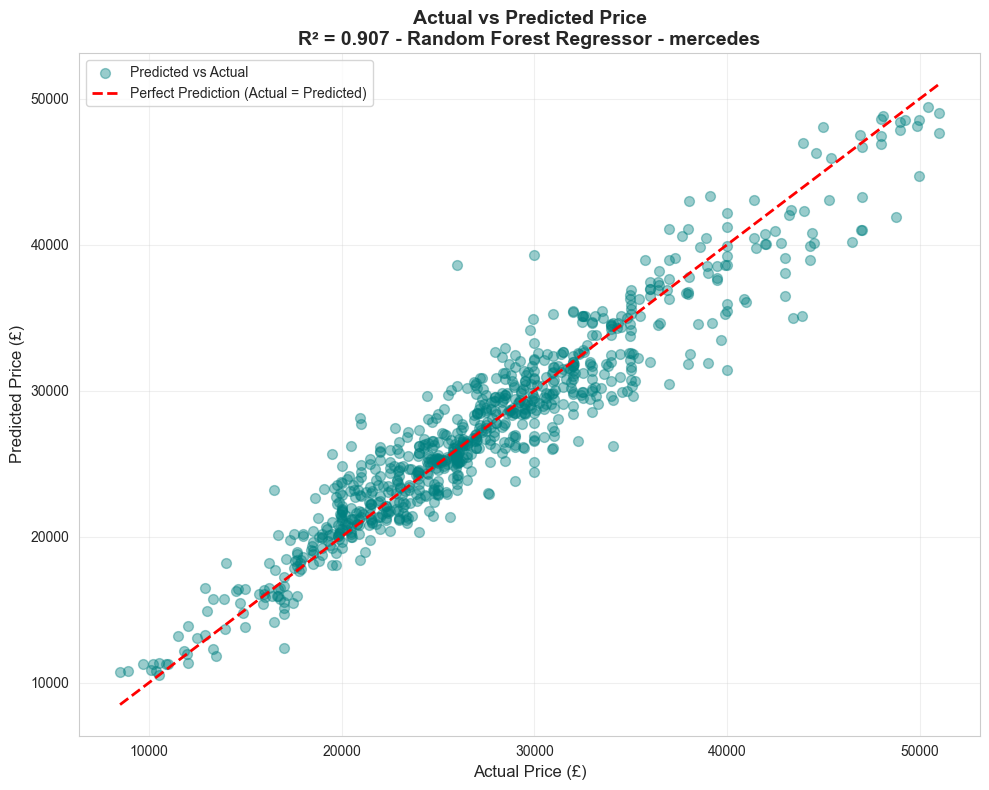

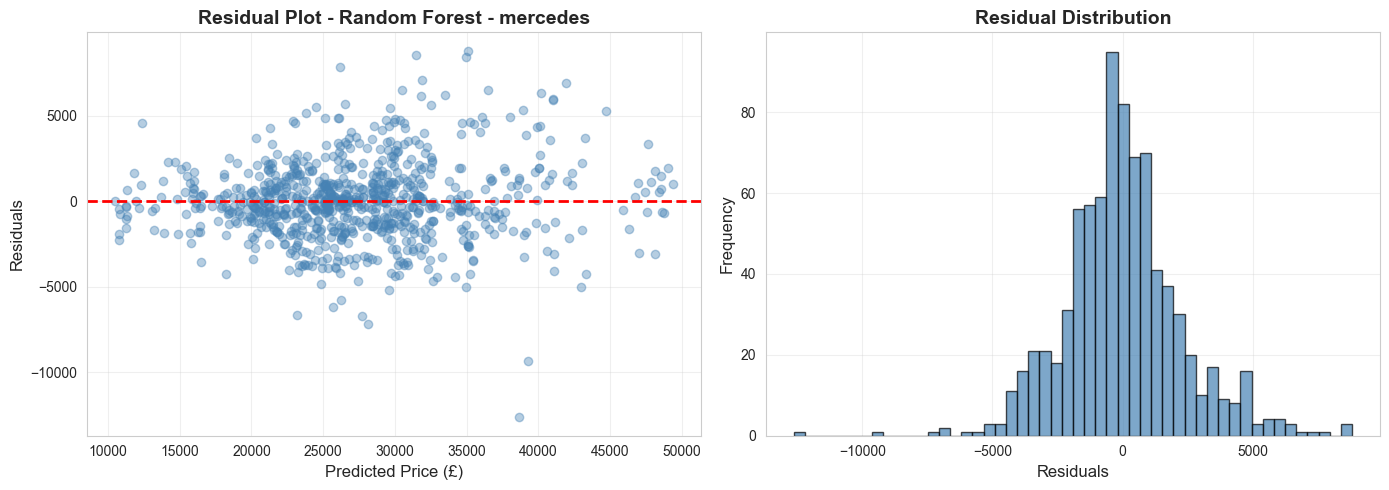

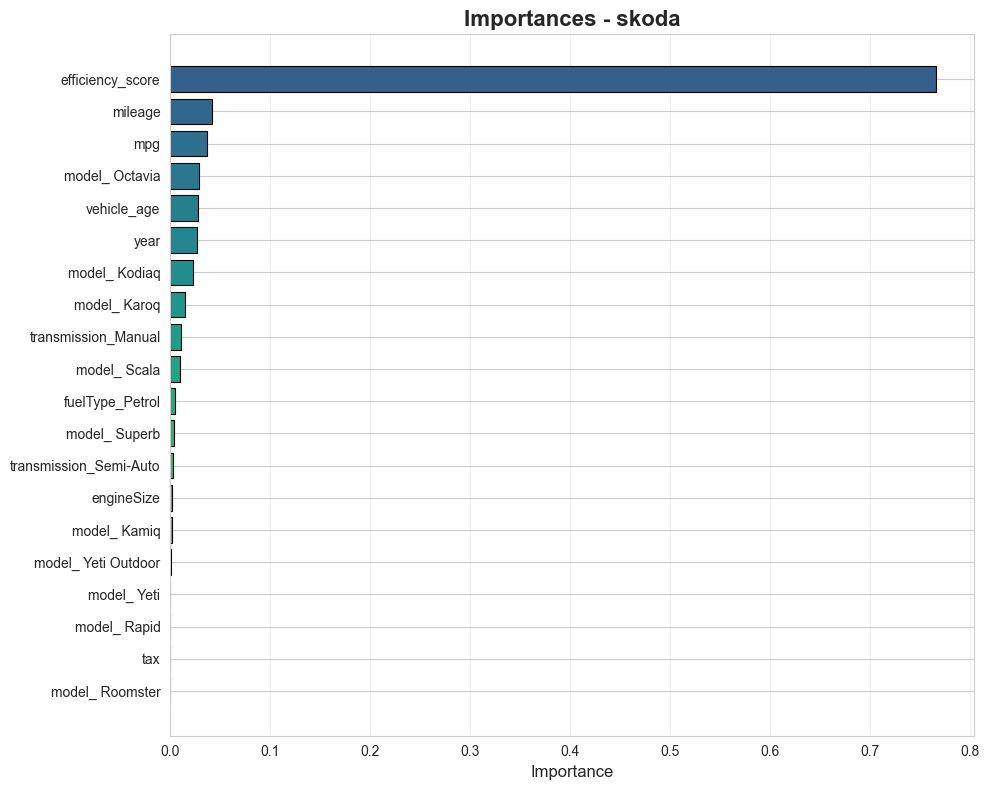

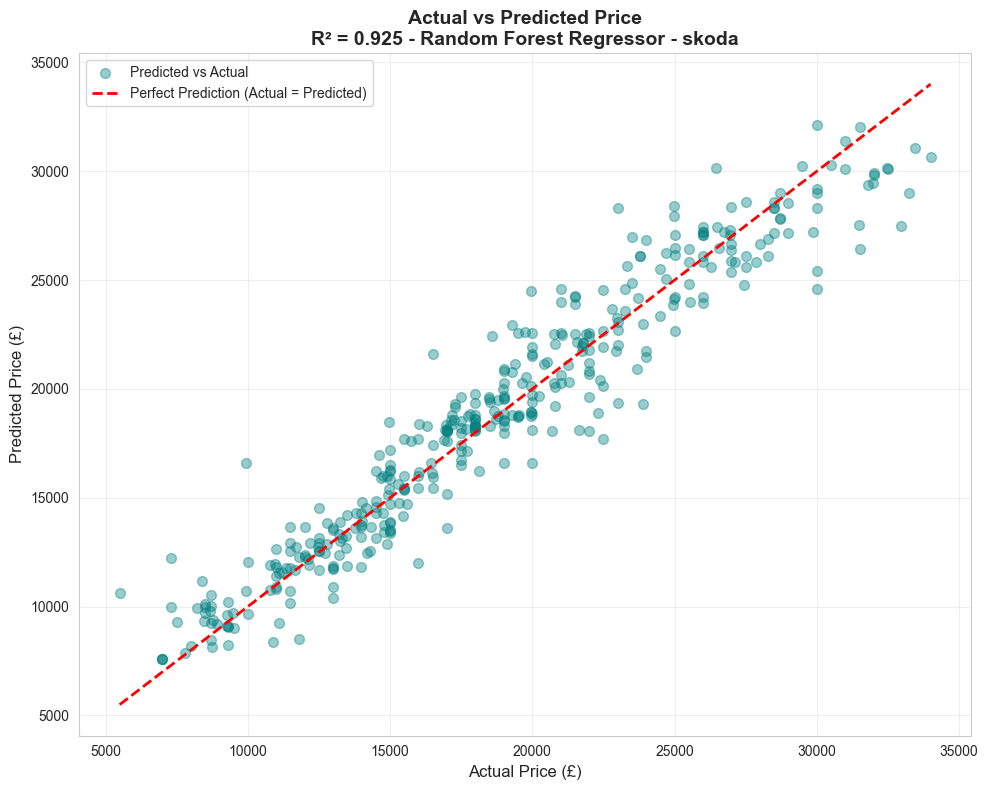

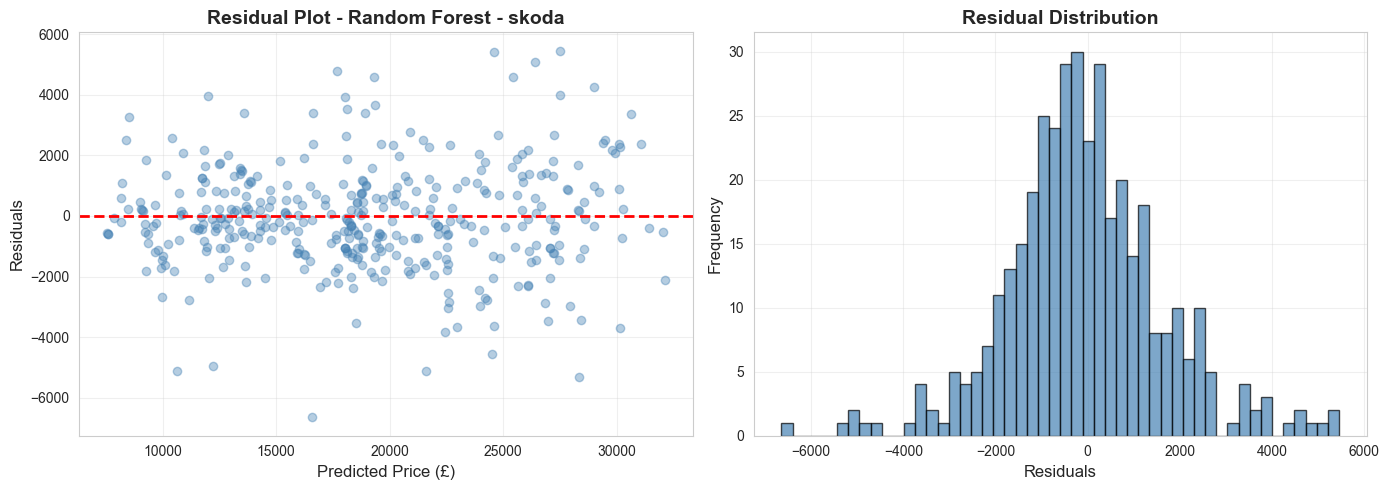

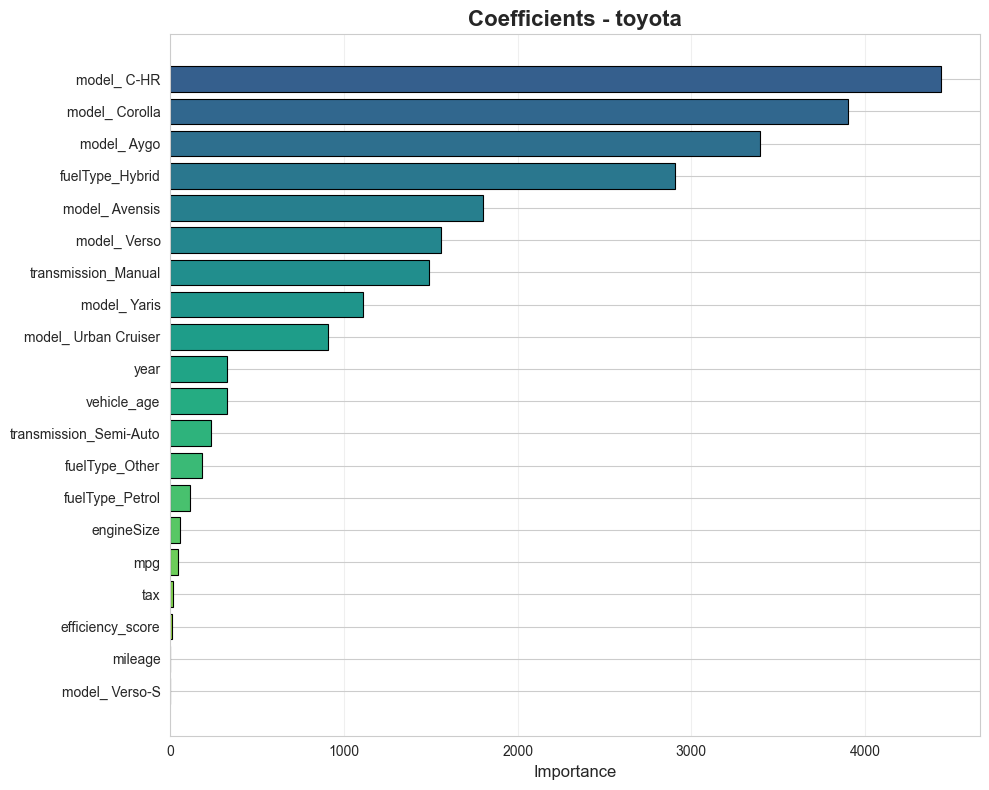

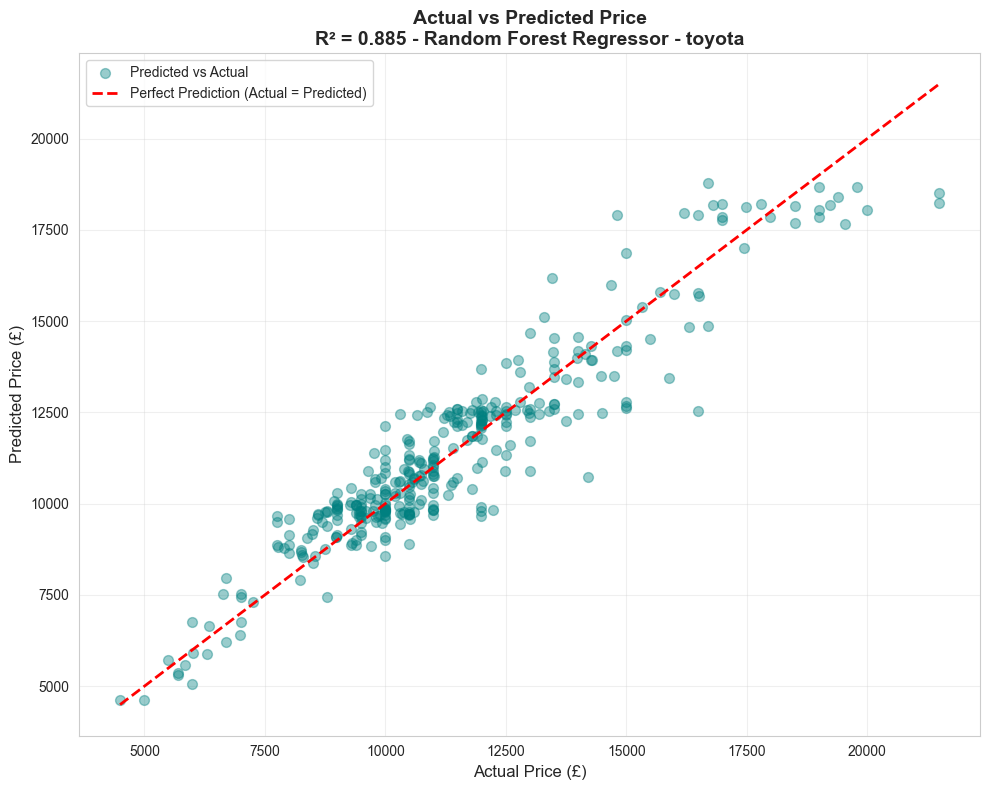

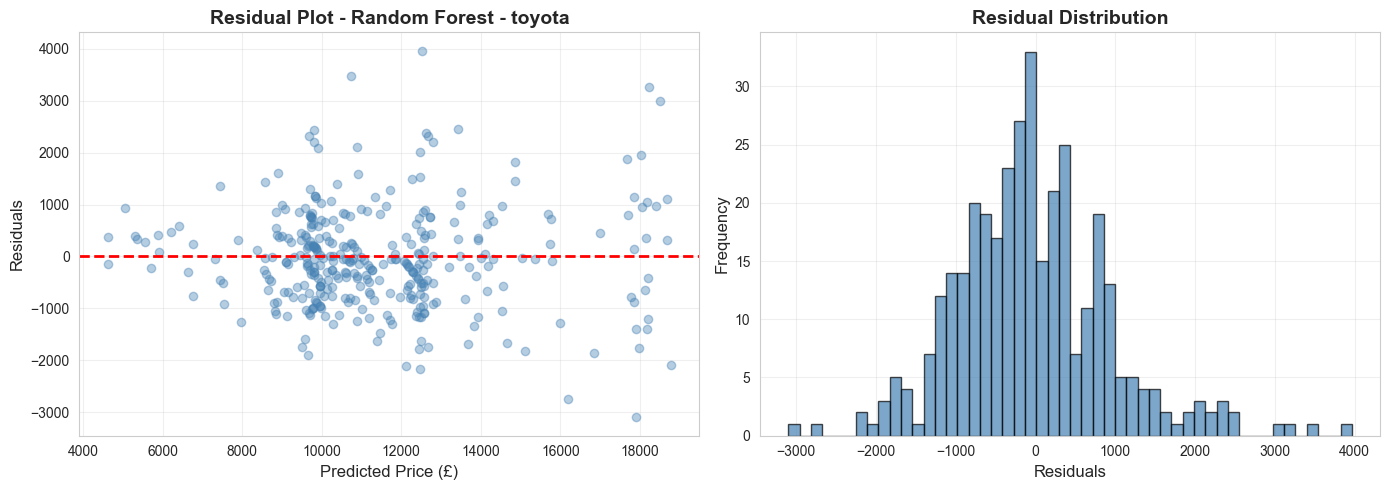

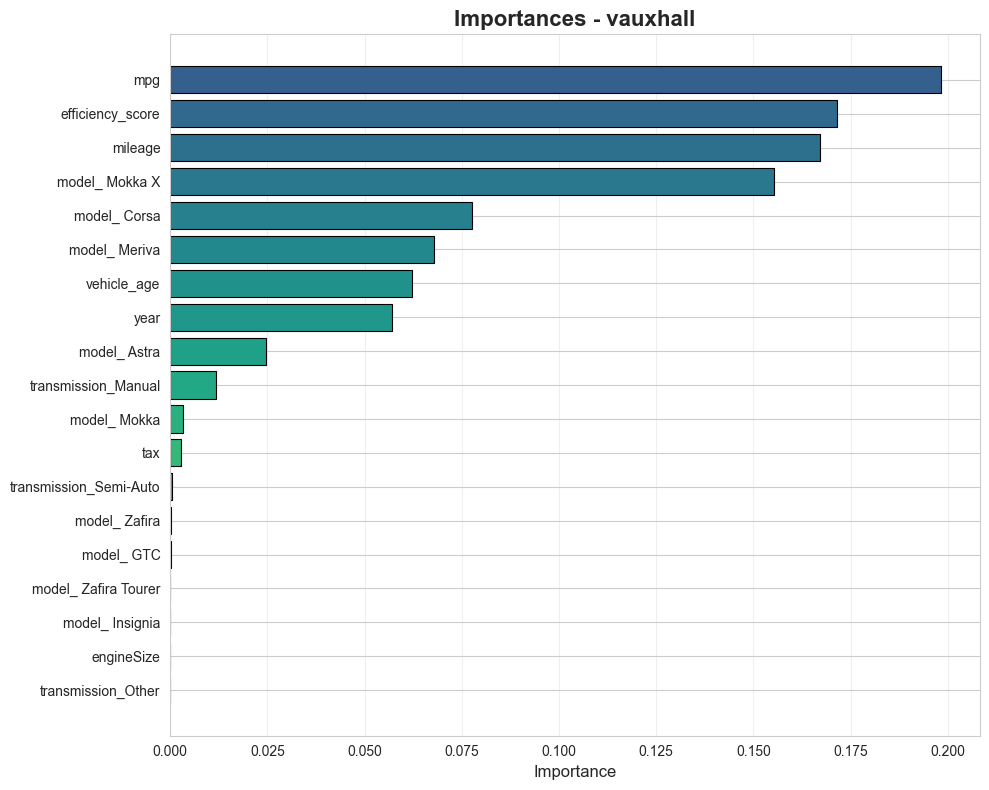

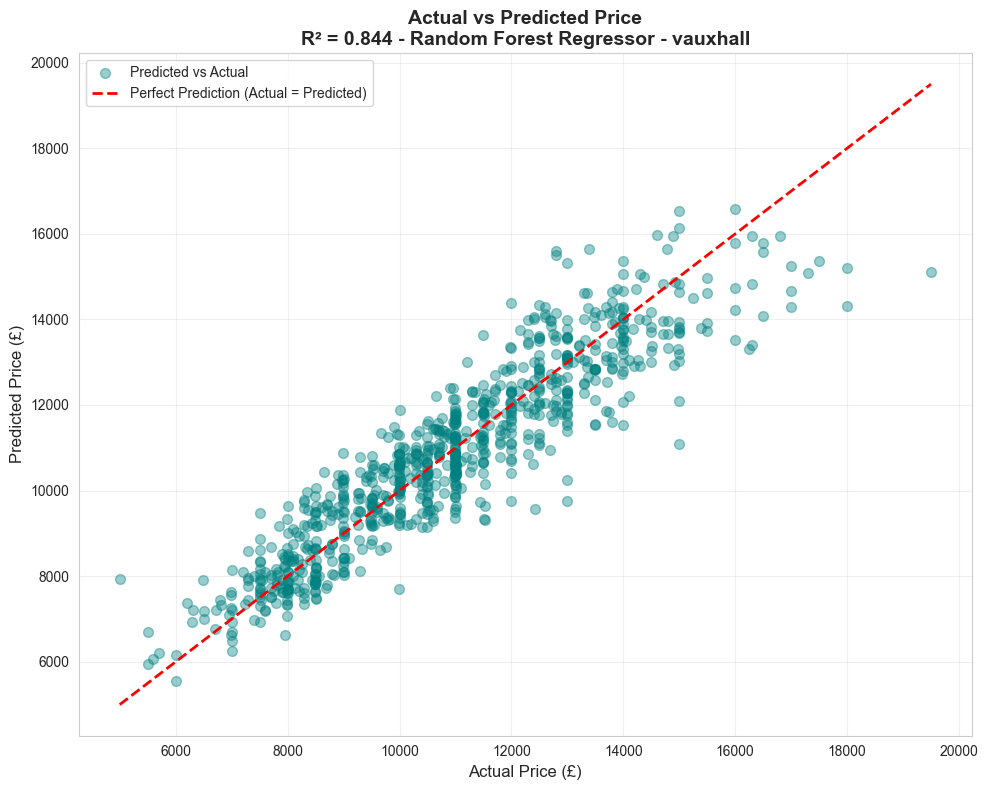

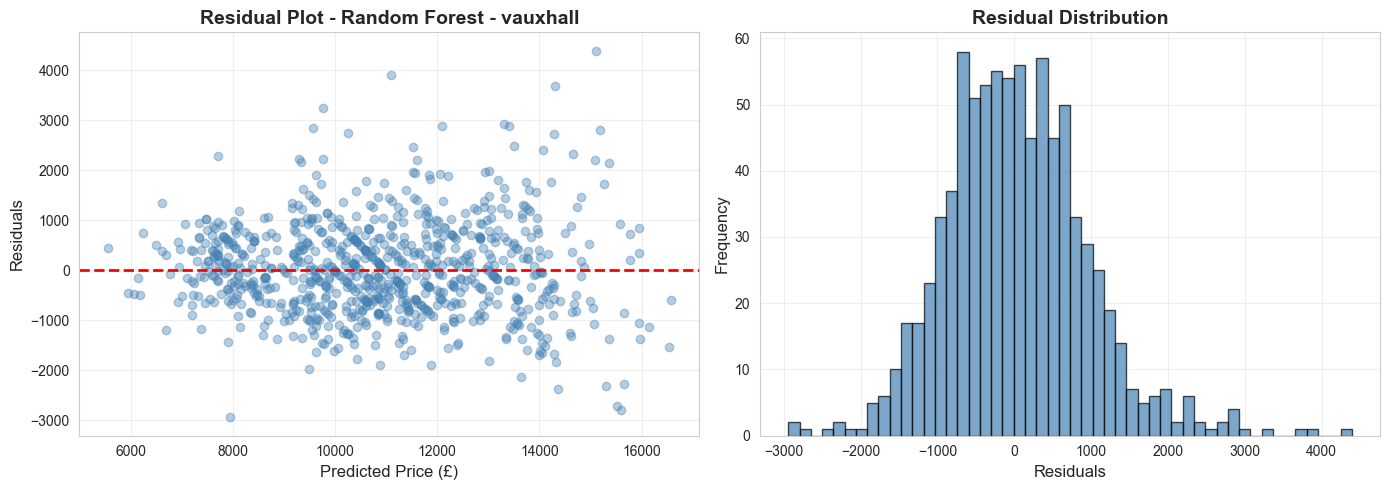

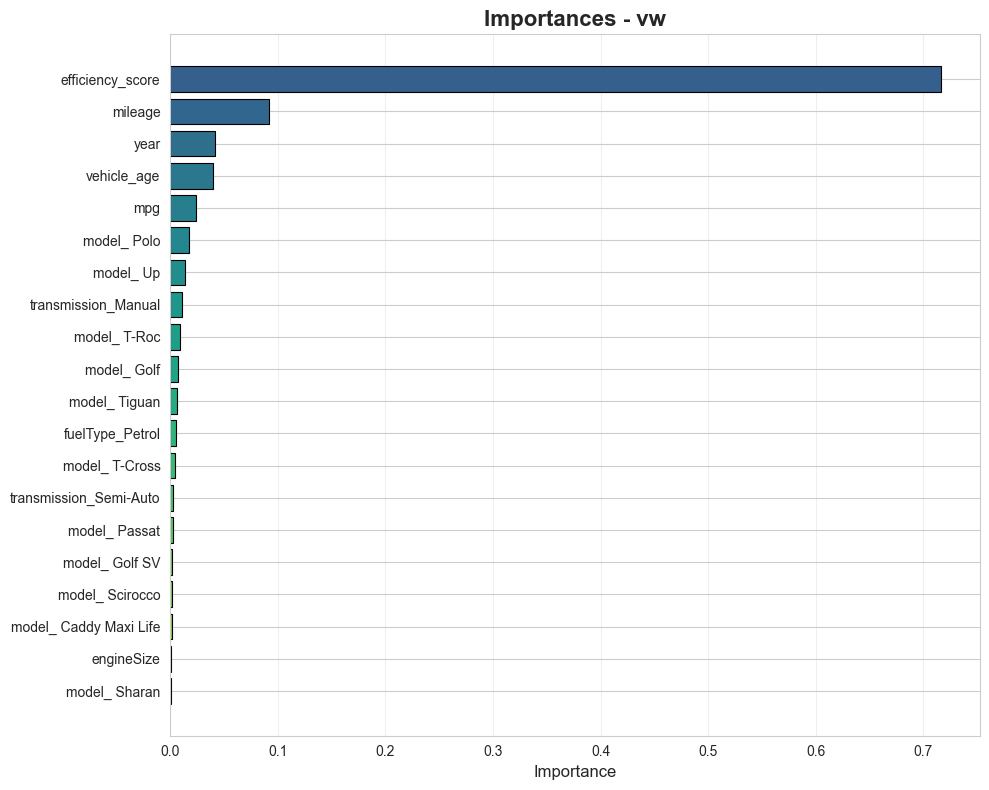

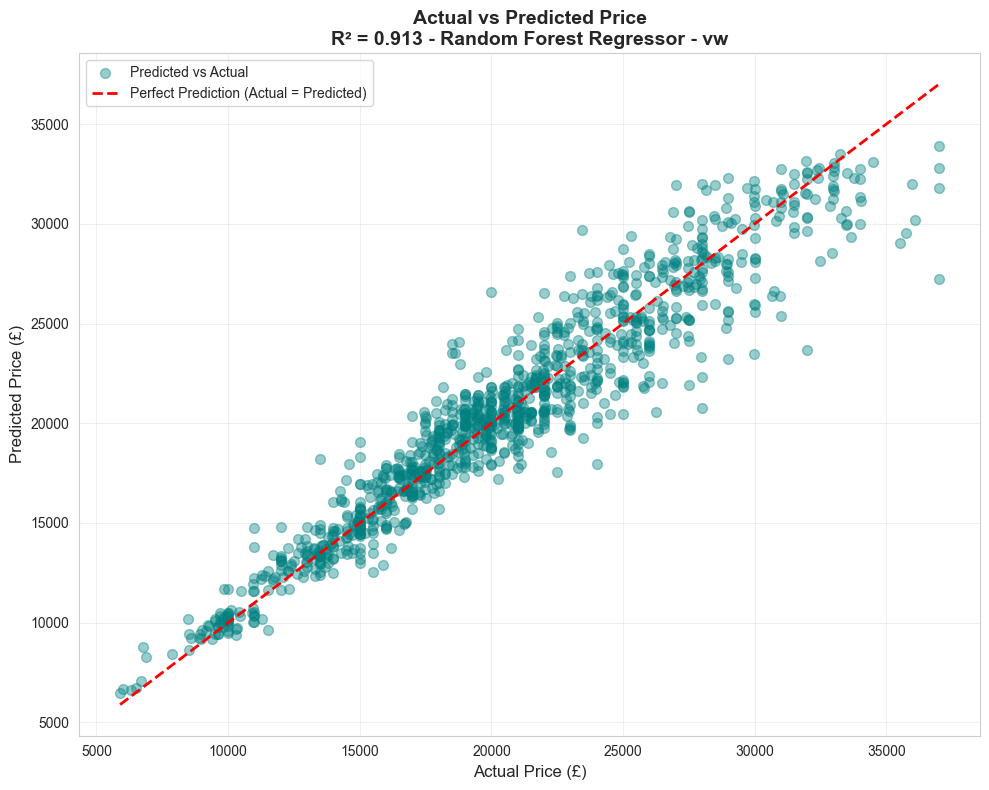

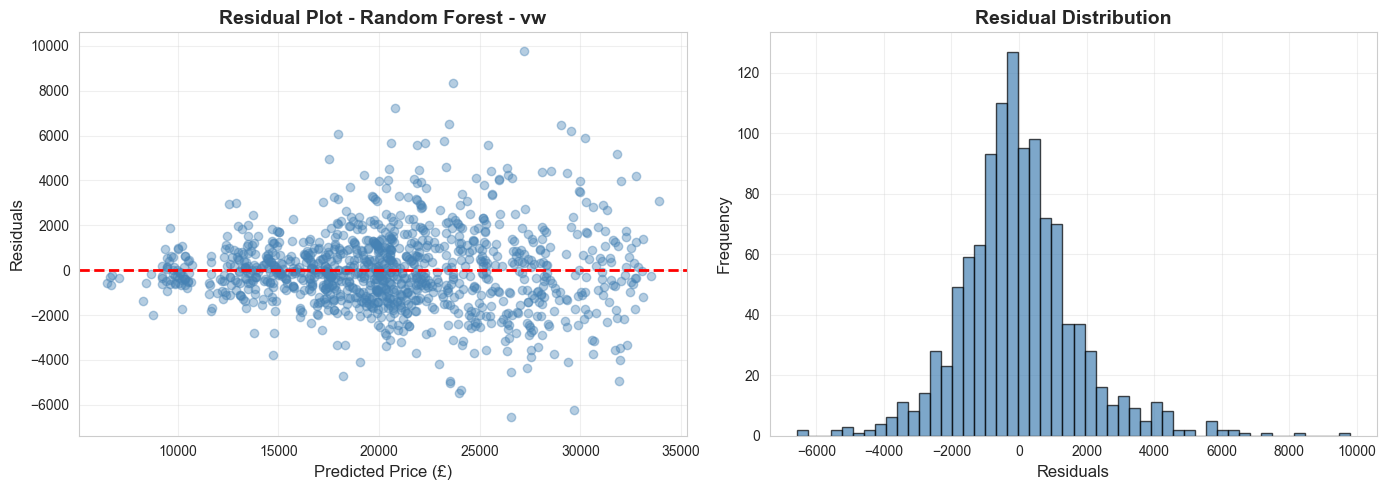

In [9]:
for make_vehicle, data in trained_models_per_make.items():
	model = data["model"]
	y_test = data['y_test']
	feature_names = data["feature_names"]
	predictions = data['predictions']
	metrics = regression_metrics(y_test, predictions)

	values, kind = get_feature_effects(model)

	n = model.n_features_in_
	feature_names = feature_names[:n]
	values = values[:n]
 
	plot_feature_importances(
		values,
		feature_names,
		f"{kind.title()}s - {make_vehicle}"
	)

	# Actual vs Predicted
	plot_actual_vs_predicted(
		y_test, 
		predictions, 
		f'Random Forest Regressor - {make_vehicle}', 
		metrics['R2']
	)

	# Residuals plot
	plot_residuals(
		y_test, 
		predictions, 
		f'Random Forest - {make_vehicle}'
	)